# Packages

In [116]:
import pandas as pd
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import nltk
import pickle
from sklearn.metrics import precision_recall_curve

In [24]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nisha\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [6]:
from nltk.corpus import stopwords

# Data

In [75]:
data = pd.read_csv('Suicide_Detection.csv')

In [5]:
data.shape

(232074, 3)

In [6]:
# class balance
data.groupby('class').size()

class
non-suicide    116037
suicide        116037
dtype: int64

This is a balanced dataset

## Sample data

### Class - suicide

In [5]:
for i, t in enumerate(data[data['class'] == 'suicide'].sample(5).text):
    print(f"{i}: {t}")

0: YeahI don't consider myself depressed or suicidal but there are times when I just know how worthless and fucked up I am and that I deserve to die. I usually get through it with minimal self harm but I know that some day in the future I'm gonna fuck up bad and hate myself for it and kill myself. And that the world will be better off for it. That's pretty much it. 
1: Who pays when I go to a hospital?Last time I was in a hospital I had health insurance but I just lost my job and am currently without insurance. Will I have to foot the bill if I check myself in? 
2: I made a mistakeI dated a girl for a year and a half and only worried about her mental health. She was extremely suicidal along with other things. When we broke up, I had noticed that all that time worrying about her made an impact on me. I wasnt watching myself. I guess it just rubbed off a little. Now fast forward, i started talking to another girl who I had such strong feelings for, but my ex was still in the picture. Dur

### Class - non-suicide

In [6]:
for i, t in enumerate(data[data['class'] == 'non-suicide'].sample(5).text):
    print(f"{i}: {t}")

0: It’s harmless prank time! Let’s use she/them pronouns with trump. 

Let’s use she/them pronouns with trump. 

Let’s use she/them pronouns with trump. 

Let’s use she/them pronouns with trump. 

Let’s use she/them pronouns with trump. 

Let’s use she/them pronouns with trump. 

Let’s use she/them pronouns with trump. 

Let’s use she/them pronouns with trump.
1: Three-way relationship Alright my friends, I’ve got a festering, interesting issue and I need some help. 

I’m a 17 M, and my best friend is the same, and we both know this 17 F and hang out with her a lot both as a three and individually. 

My relationship with her is probably best described as friends, who have had sex and would do so again because we are both sexually and emotionally attracted to each other. In fact, we both admitted we would like to be in an official relationship together only a few weeks ago. I stopped this happening because I’m currently upholding a policy of avoiding any romantic emotional investment so

### Observations

* Class suicidal text likely to be long than non-suicidal text
* Some misspelled words
* Some sentences have emojis
* Text blobs can be very long, so truncating is needed

# Train-test split

In [76]:
data_ = data.sample(data.shape[0], random_state=8)

In [77]:
data_['text_lower'] = data_.text.str.lower()

In [78]:
data_['label'] = data['class'].apply(lambda x: 1 if x == 'suicide' else 0)

In [79]:
data_.reset_index(drop=True, inplace=True)

In [80]:
split = int(0.9 * data_.shape[0])

In [81]:
train_sentences = list(data_.text_lower[:split])
train_labels = list(data_.label[:split])
test_sentences = list(data_.text_lower[split:])
test_labels = list(data_.label[split:])

In [82]:
len(train_sentences), len(test_sentences)

(208866, 23208)

# Explore text parameters

## Length of sentences

### Label - 0

In [20]:
text_len_lab_0 = [len(s) for s in train_sentences[train_labels == 0]]

In [22]:
max(text_len_lab_0), min(text_len_lab_0)

(40106, 8)

In [27]:
np.percentile(text_len_lab_0, 50), np.percentile(text_len_lab_0, 75)

(166.0, 321.0)

### Label - 1

In [24]:
text_len_lab_1 = [len(s) for s in train_sentences[train_labels == 1]]

In [25]:
max(text_len_lab_1), min(text_len_lab_1)

(40297, 3)

In [28]:
np.percentile(text_len_lab_1, 50), np.percentile(text_len_lab_1, 75)

(654.0, 1294.0)

Suicide text seems to lengthy compared to non-suicidal text (50th percentile for number words in a blob 654 vs 166)

## Unique words

In [47]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sentences)
word_counts = tokenizer.word_counts

In [54]:
# unique words
len(word_counts)

190576

In [55]:
w_cnts = [v for k, v in word_counts.items()]

In [56]:
min(w_cnts), max(w_cnts)

(1, 1579091)

In [75]:
np.percentile(w_cnts, 85), np.percentile(w_cnts, 90)

(8.0, 18.0)

Only 10% of the words have significant number of occurrences (which 18 or more occurrences)

# Utility functions

In [12]:
# Plot Utility
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

# Find best architecture and parameters

Dev set is created to find model hyperparemeters faster

In [14]:
dev_train_sentences = train_sentences[:5000]
dev_train_labels = train_labels[:5000]

In [15]:
dev_test_sentences = test_sentences[:1000]
dev_test_labels = test_labels[:1000]

In [17]:
dev_train_sentences[:5]

["i feel horrible. i don't know where to post this.\n\ni feel absolutely horrible.\n\ni can't sleep,i'm burnt out,i have no motivation to do anything and i'm done with my fucking life.\n\nlast place i thought i can find help is no more,so i'm back on reddit.\n\neverything is falling apart and i can't keep my shit together.\n\nmy parents became true assholes and play on my emotions which fucks with my head.\n\ni should kill myself",
 "how much pizotifen (1.5mg) would it take to kill myself?i'm a 20 year old male, who weighs 9st 8lbs and take 2 (1.5mg) pizotifen tablets each night to help with both migraines and sleep. however, for little over a year now i have wanted to end my life, nothing seems to have meaning for me anymore, i'm completely desensitised to most emotion.\n\nhow many tablets would it take for me to die, just out of curiosity. i am not currently in the mindset of killing myself as i need to be around to watch my nephew grow up, but... if worst comes to worst, it would be

## Understand vocab_size, max_length, embedding_dim, lstm_dim, dense_dim 

Tunning for hyperparameters one at a time

In [10]:
trunc_type='post'
oov_tok = "<OOV>"

In [87]:
def get_padded_sequences(train_sentences, test_sentences, vocab_size, oov_tok, max_length, trunc_type):
    tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
    tokenizer.fit_on_texts(train_sentences)
    
    with open('tokenizer.pickle', 'wb') as f:
        pickle.dump(tokenizer, f)
    
    train_sequences = tokenizer.texts_to_sequences(train_sentences)
    train_padded = pad_sequences(train_sequences, maxlen=max_length, truncating=trunc_type)
    test_sequences = tokenizer.texts_to_sequences(test_sentences)
    test_padded = pad_sequences(test_sequences, maxlen=max_length, truncating=trunc_type)
    
    return train_padded, test_padded

In [20]:
def train_model(train_padded, train_labels, test_padded, test_labels, vocab_size, embedding_dim, max_length, lstm_dim, dense_dim):
    model_lstm = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(lstm_dim)),
        tf.keras.layers.Dense(dense_dim, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    history = model_lstm.fit(train_padded, np.array(train_labels), batch_size=1024, epochs=50, 
                                    validation_data=(test_padded, np.array(test_labels)), verbose=0)
    
    return history

In [43]:
def check_val_accuracy(vocab_size, max_length, embedding_dim, lstm_dim, dense_dim, train_s=dev_train_sentences, 
                       test_s=dev_test_sentences):
    dev_train_padded, dev_test_padded = get_padded_sequences(train_s, test_s, vocab_size, oov_tok, max_length, 
                                                             trunc_type)
    history = train_model(dev_train_padded, dev_train_labels, dev_test_padded, dev_test_labels, vocab_size, embedding_dim, max_length, 
                          lstm_dim, dense_dim)
    print(max(history.history['val_accuracy']))

In [32]:
check_val_accuracy(vocab_size=20000, max_length=300, embedding_dim=32, lstm_dim=64, dense_dim=16)

0.8939999938011169


In [33]:
check_val_accuracy(vocab_size=25000, max_length=300, embedding_dim=32, lstm_dim=64, dense_dim=16)

0.8970000147819519


In [34]:
check_val_accuracy(vocab_size=15000, max_length=300, embedding_dim=32, lstm_dim=64, dense_dim=16)

0.8889999985694885


In [50]:
check_val_accuracy(vocab_size=30000, max_length=300, embedding_dim=32, lstm_dim=64, dense_dim=16)

0.8939999938011169


Best vocab size seems to be 25000 words

In [52]:
check_val_accuracy(vocab_size=25000, max_length=200, embedding_dim=32, lstm_dim=64, dense_dim=16)

0.8970000147819519


In [53]:
check_val_accuracy(vocab_size=25000, max_length=400, embedding_dim=32, lstm_dim=64, dense_dim=16)

0.8930000066757202


Keeping max length at 300 words

In [56]:
check_val_accuracy(vocab_size=25000, max_length=300, embedding_dim=64, lstm_dim=64, dense_dim=16)

0.8989999890327454


In [57]:
check_val_accuracy(vocab_size=25000, max_length=300, embedding_dim=16, lstm_dim=64, dense_dim=16)

0.8970000147819519


In [58]:
check_val_accuracy(vocab_size=25000, max_length=300, embedding_dim=128, lstm_dim=64, dense_dim=16)

0.890999972820282


Keeping embedding_dim at 64 words

In [59]:
check_val_accuracy(vocab_size=25000, max_length=300, embedding_dim=64, lstm_dim=32, dense_dim=16)

0.8989999890327454


Keeping lstm_dim at 64

In [22]:
check_val_accuracy(vocab_size=25000, max_length=300, embedding_dim=64, lstm_dim=64, dense_dim=8)

0.8989999890327454


In [23]:
check_val_accuracy(vocab_size=25000, max_length=300, embedding_dim=64, lstm_dim=64, dense_dim=32)

0.8980000019073486


Keeping dense_dim at 16

## Remove stopwords

Check if removing stop words helps in model performance

In [29]:
stop_words = set(stopwords.words('english'))

In [30]:
len(stop_words)

179

In [32]:
dev_train_sentences_stp = []

In [39]:
for s in dev_train_sentences:
    dev_train_sentences_stp.append(" ".join([w for w in s.split() if w not in stop_words]))

In [42]:
dev_test_sentences_stp = []
for s in dev_test_sentences:
    dev_test_sentences_stp.append(" ".join([w for w in s.split() if w not in stop_words]))

In [47]:
check_val_accuracy(vocab_size=25000, max_length=300, embedding_dim=64, lstm_dim=64, dense_dim=16, train_s=dev_train_sentences_stp, 
                       test_s=dev_test_sentences_stp)

0.8999999761581421


There is some improvement from removing stopwords 

# Final model

## Stop word removal

In [8]:
stop_words = set(stopwords.words('english'))

In [83]:
train_sentences_stp = []
for s in train_sentences:
    train_sentences_stp.append(" ".join([w for w in s.split() if w not in stop_words]))

In [84]:
test_sentences_stp = []
for s in test_sentences:
    test_sentences_stp.append(" ".join([w for w in s.split() if w not in stop_words]))

In [85]:
len(train_sentences_stp), len(test_sentences_stp)

(208866, 23208)

## Model

In [88]:
train_padded, test_padded = get_padded_sequences(train_sentences_stp, test_sentences_stp, 25000, oov_tok, 300, trunc_type)

In [22]:
# find best validation model
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                                monitor='val_accuracy',
                                                save_best_only=True,
                                                save_weights_only=False)

In [32]:
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(25000, 64, input_length=300),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dropout(0.8),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

In [33]:
train_padded.shape, test_padded.shape

((208866, 300), (23208, 300))

In [34]:
history = model_lstm.fit(train_padded, np.array(train_labels), batch_size=1024, epochs=50, 
                                validation_data=(test_padded, np.array(test_labels)), verbose=1, callbacks=[checkpoint])

Epoch 1/50
204/204 [==============================] - 35s 156ms/step - loss: 0.3008 - accuracy: 0.8771 - val_loss: 0.1777 - val_accuracy: 0.9360
Epoch 2/50
204/204 [==============================] - 31s 153ms/step - loss: 0.1658 - accuracy: 0.9444 - val_loss: 0.1688 - val_accuracy: 0.9393
Epoch 3/50
204/204 [==============================] - 31s 153ms/step - loss: 0.1448 - accuracy: 0.9518 - val_loss: 0.1728 - val_accuracy: 0.9405
Epoch 4/50
204/204 [==============================] - 31s 153ms/step - loss: 0.1426 - accuracy: 0.9524 - val_loss: 0.1637 - val_accuracy: 0.9417
Epoch 5/50
204/204 [==============================] - 31s 153ms/step - loss: 0.1168 - accuracy: 0.9612 - val_loss: 0.1588 - val_accuracy: 0.9444
Epoch 6/50
204/204 [==============================] - 31s 154ms/step - loss: 0.1028 - accuracy: 0.9663 - val_loss: 0.1757 - val_accuracy: 0.9459
Epoch 7/50
204/204 [==============================] - 31s 153ms/step - loss: 0.0910 - accuracy: 0.9706 - val_loss: 0.1639 - val_ac

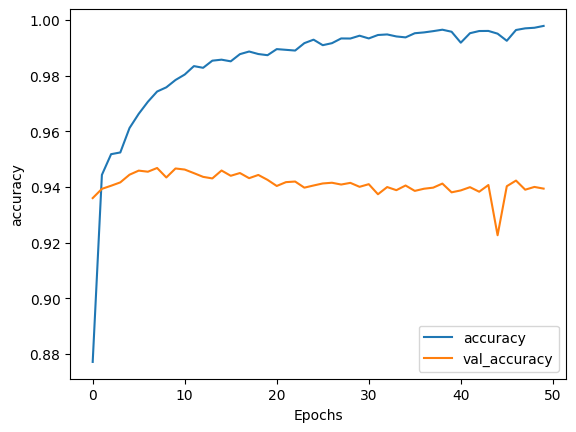

In [35]:
plot_graphs(history, 'accuracy')

We reached the best model around 8th epoch

# Make predictions

Following examples were generated using chat-gpt

In [142]:
suicidal_thoughts = [
    "I can't keep living like this. Suicide seems like the only way out.",
    "Everyone would be better off without me. I'm just a burden on others.",
    "I don't want to suffer anymore. Ending my life would be a relief.",
    "Life is too painful. I don't see any hope for the future.",
    "I feel so hopeless and alone. Suicide is the only solution."
]

non_suicidal_thoughts = [
    "I'm excited for my vacation next month. It will be great to get away for a while.",
    "I'm proud of myself for achieving my goals at work this year.",
    "I love spending time with my family and friends. They bring so much joy to my life.",
    "I enjoy exercising and taking care of my physical health.",
    "I feel content when I'm reading a good book or listening to music."
]

neutral_thoughts = [
    "I need to go grocery shopping today and pick up some supplies.",
    "The weather outside is nice and sunny.",
    "I have a meeting at work in an hour. I need to prepare for it.",
    "I'm thinking about what to make for dinner tonight.",
    "I need to clean my house this weekend and do some laundry."
]

In [63]:
def remove_stop_words(s):
    s = s.lower()
    return [" ".join([w for w in s.split() if w not in stop_words])]

In [3]:
def load_tokernizer():
    with open('tokenizer.pickle', 'rb') as f:
        out = pickle.load(f)
    return out

In [12]:
tokenizer = load_tokernizer()

In [15]:
max_length = 300

In [19]:
model = tf.keras.models.load_model('./best_model.h5')

In [65]:
def predict_prob(text):
    tokens = tokenizer.texts_to_sequences(remove_stop_words(text))
    pad_seq = pad_sequences(tokens, maxlen=max_length, truncating=trunc_type)
    return model.predict(pad_seq, verbose=0)[0][0]

In [70]:
for t in suicidal_thoughts:
    print(f"{t} : {predict_prob(t)}")

I can't keep living like this. Suicide seems like the only way out. : 0.9835975766181946
Everyone would be better off without me. I'm just a burden on others. : 0.9083202481269836
I don't want to suffer anymore. Ending my life would be a relief. : 0.9828774929046631
Life is too painful. I don't see any hope for the future. : 0.9008930325508118
I feel so hopeless and alone. Suicide is the only solution. : 0.9921825528144836


In [71]:
for t in non_suicidal_thoughts:
    print(f"{t} : {predict_prob(t)}")

I'm excited for my vacation next month. It will be great to get away for a while. : 0.24953334033489227
I'm proud of myself for achieving my goals at work this year. : 0.01673825830221176
I love spending time with my family and friends. They bring so much joy to my life. : 0.5349147319793701
I enjoy exercising and taking care of my physical health. : 0.0475882850587368
I feel content when I'm reading a good book or listening to music. : 0.020517263561487198


In [72]:
for t in neutral_thoughts:
    print(f"{t} : {predict_prob(t)}")

I need to go grocery shopping today and pick up some supplies. : 0.49093037843704224
The weather outside is nice and sunny. : 0.057429488748311996
I have a meeting at work in an hour. I need to prepare for it. : 0.023196812719106674
I'm thinking about what to make for dinner tonight. : 0.5537188053131104
I need to clean my house this weekend and do some laundry. : 0.019268695265054703


Model is performing decently on unseen data with likelihood of suicide being greater than 90% in the case of suicidal thoughts

# Precision and Recall in test set

In [90]:
test_predictions = model.predict(test_padded)

726/726 [==============================] - 15s 21ms/step


In [98]:
test_predictions = test_predictions.flatten()

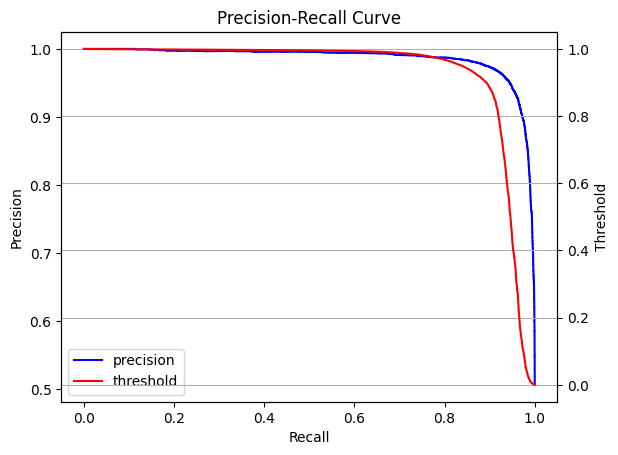

In [141]:
precision, recall, thresholds = precision_recall_curve(np.array(test_labels), test_predictions)
thresholds = np.insert(thresholds, 0, 0)

fig, ax1 = plt.subplots()

# Plot the precision-recall curve on the left axis
ax1.plot(recall, precision, color='blue', label='precision')
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('Precision-Recall Curve')

# Add threshold values on the right axis
ax2 = ax1.twinx()
ax2.plot(recall, thresholds, color='red', label='threshold')
ax2.set_ylabel('Threshold')

# Add a legend
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='best')
ax2.grid()

plt.show()

In this application, precision is more important to us, so that we do not create unwarranted panic. Therefore, still keeping recall also at a healthy level, a threshold **0.9** on predcition probabilties seems good enough